# Reconstruction Error analysis for any new set of GT sequences

This notebook contains all the steps necessary to calculate the RE and FAS scores and generate plots for sequences from any new GT family of unknown fold. It is advised to have as many sequences from each of the new families as possible with at most 95% sequence similarity between them.<br>
This step can be run using the outputs from 1-Preprocessing.ipynb

## 1. Imports, functions and constants

In [1]:
import os

from CNN import *
from Utils_auto import *
from Utils import *
from Autoencoder import *

from sklearn import preprocessing

In [2]:
## Constants

# Vocabulary for ss prediction
vocab = {'C': [0,0,1], 'H': [0,1,0], 'E': [1,0,0], '-':[0,0,0]}

# Transform the labels from String to Integer via LabelEncoder
le_fold = preprocessing.LabelEncoder()
le_fam = preprocessing.LabelEncoder()

# Defining cluster names
grp=['gta0','gta1','gtb0','gtb1','gtb2','gtc0','gtc1','gtc2','gtlyso']

# Define criterion and read in the models for each subcluster
criterion = nn.MSELoss(reduction="sum")

# use of GPU
cuda_gpu=False

## Reading saved models and RE for GT-A, -B, -C and -lyso sequences

In [3]:
# Reading the main autoencoder model
f=open( "../PretrainedModels/Autoencoder_gtmain.pickle", "rb" )
model_main = CPU_Unpickler(f).load()

# Reading the 9 cluster autoencoder models
model=dict()
for i in grp:
    f=open( "../PretrainedModels/Autoencoder_"+i+".pickle", "rb" )
    model[i] = CPU_Unpickler(f).load()

# Reading the RE data for training sequences from the main autoencoder
re_train_main=pd.read_csv("../Datasets/RE_data/rerr_gtmain_training.csv")

# Reading the RE data for training, OOC and OOF sequences from the cluster autoencoders
re_train=dict()
re_ooc=dict()
re_oof=dict()
for i in grp:
    train="../Datasets/RE_data/rerr_"+i+"_training.csv"
    ooc="../Datasets/RE_data/rerr_"+i+"_ooc.csv"
    oof="../Datasets/RE_data/rerr_"+i+"_oof.csv"
    re_train[i]=pd.read_csv(train)
    re_ooc[i]=pd.read_csv(ooc)
    re_oof[i]=pd.read_csv(oof)

## Reading processed tables for new set of sequences

In [4]:
# Read in the test dataset
df_test=pd.read_csv("../Datasets/gtu/gtu.processed.csv")
df_test.shape

(4072, 8)

In [5]:
df_test.head()

,Name,fold,family,q3seq,rawseq,q3seqTokens,rawseqTokens,paddings
0,GT69-u|AAY89392|C.gattiiVGIR265_Fungi,u,GT69-u,------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------CCCCCCCCCCCCCCCCHHHHHCCCCCCCCCCCCCCCCCHHHHHHHHHHHCCCEEEEEEECCCCCCHHHHHHHHHHHHHHHHCHHHEEEEEEECCCCCCHHHHHHHHHHHHHHCCCCEEEECCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHCCCCCCCEEEEECCCCCCHHHHHHHHHHHCCCC---------------------------------------------------------------------------------------------------------...,------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------RYAPLVGYKKPWSNSGWLRKLFGGSDAHSTMASITGNDRMDVIKRDLQARQHKYFFAINLYNSFDVIPDIFATLFRAAAILGYHNVFVSIYENGSNDQTKALLKIFDALARTVGLRIIIRTSMRTRGLFNHRIEYLAEVRNAAMLPLHELRDNDGEVFDSVVFMNDILPCVDDLLELIWQSRRQN---------------------------------------------------------------------------------------------------------...,"['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', ...","['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', ...",306
1,GT69-u|AAC13946|C.neoformans_Fungi,u,GT69-u,--------------------------------------------------------------------------------------------------------------------------------------------------------------------------CCCCHHHHHHHHHHHHCCCCCCCHHHHCCCHHHHHHHHHHHHHHHCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHHHHHHHHHCCCEEEEEEECCCCCHHHHHHHHHHHHHHHHHCHHHEEEEEEECCCCCCHHHHHHHHHHHHHHCCCEEEEECCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHCCCCCCCCEEEEECCCCCCHHHHHHHHHCCCCCCCCEECCCCEEEECCCCCCEEEECEEEECCCCCECCCCCHHHHCCCHHHHHHHHHCCCEEEEECCCEEEEECCHHHCCCCCCEEECCCCCCCCCCCCCHHHEHHHHHHCCCCCEEEECCEEEECCHHHHHHHCCCCCCCHHHCCCEECCCCCCCCCCCHHHHHHCCCCCCCCCCCCCCCCEEECCCCEEEEECCCCCCCCC...,--------------------------------------------------------------------------------------------------------------------------------------------------------------------------MLPSIEQRLHILQLISTLSAHHTKECLRNPQPLYVEQVKERYAPLVGYKKPWSNSGWLGRLFGGKSDSQSTMASTTGNDRLDNIKRDLQARQHKYFFAINLYNSFDVIPDLFATLFRAAAILGYHNVFVSIYENGSNDQTKALLKIFDALARTVGLRIIIRTSMRTRGLFNHRIEYLAEVRNAAMLPLHELRDNDGEVFDSVVFMNDILPCVDDLLELIWQSRRQNAGITCAADYMYHDDIGAPVFYDNWVARDINGTALENAPFEQIFHHTESNHRFQRHLPIQVQSCWNGIAILDPTPFYEPPHVRFRMANLAQGECSASECSLICNDYFNAGYGRIIMVPRVKLAYDRKVWDIIHPERRNLTAIRGYKRIGGLPDDPHSDPQDRSWYGPHDRLFTPEETEELEFVPGPEYVWCWGWDGAGDLD...,"['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 

## RE calculation and analysis against main autoencoder

In [6]:
# Calculate RE against main autoencoder
# This step can take long; 
# To avoid, load already provided dataset by uncommenting last line of this block 
# and comment the line below
re_test_main = reconstruction_error_calculation(model_main, df_test, le_fam, le_fold, cuda_gpu, criterion, vocab)

### re_test_main=pd.read_csv("../Datasets/gtu/gtu.RE_main.csv")

/home/zzl/anaconda3/envs/GT_test/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [7]:
# Calculate median RE for every family
re_test_main_median=re_test_main.groupby('Family').median().reset_index().sort_values('Err')
re_test_main_median

,Family,Err
16,GT53-u,0.084841
4,GT105-u,0.085035
10,GT110-u,0.087367
22,GT89-u,0.091285
21,GT76-u,0.091351
5,GT106-u,0.093037
8,GT109-u,0.096032
12,GT29-u,0.098119
3,GT103-u,0.102328
6,GT107-u,0.102565


In [8]:
# Save RE for the test dataset to file
re_test_main.to_csv("../ExampleOutputs/gtu.RE_main.csv",index=False)

In [9]:
# Save median RE to a file
re_test_main_median.to_csv("../ExampleOutputs/gtu.medianRE_main.csv",index=False)

### RE analysis for main autoencoder

#### Fit extreme value distribution to the training error distribution

95% CI upper bound: 0.10659970165381911
99% CI upper bound: 0.14685000308245982
Median RE: 0.10390087589621544


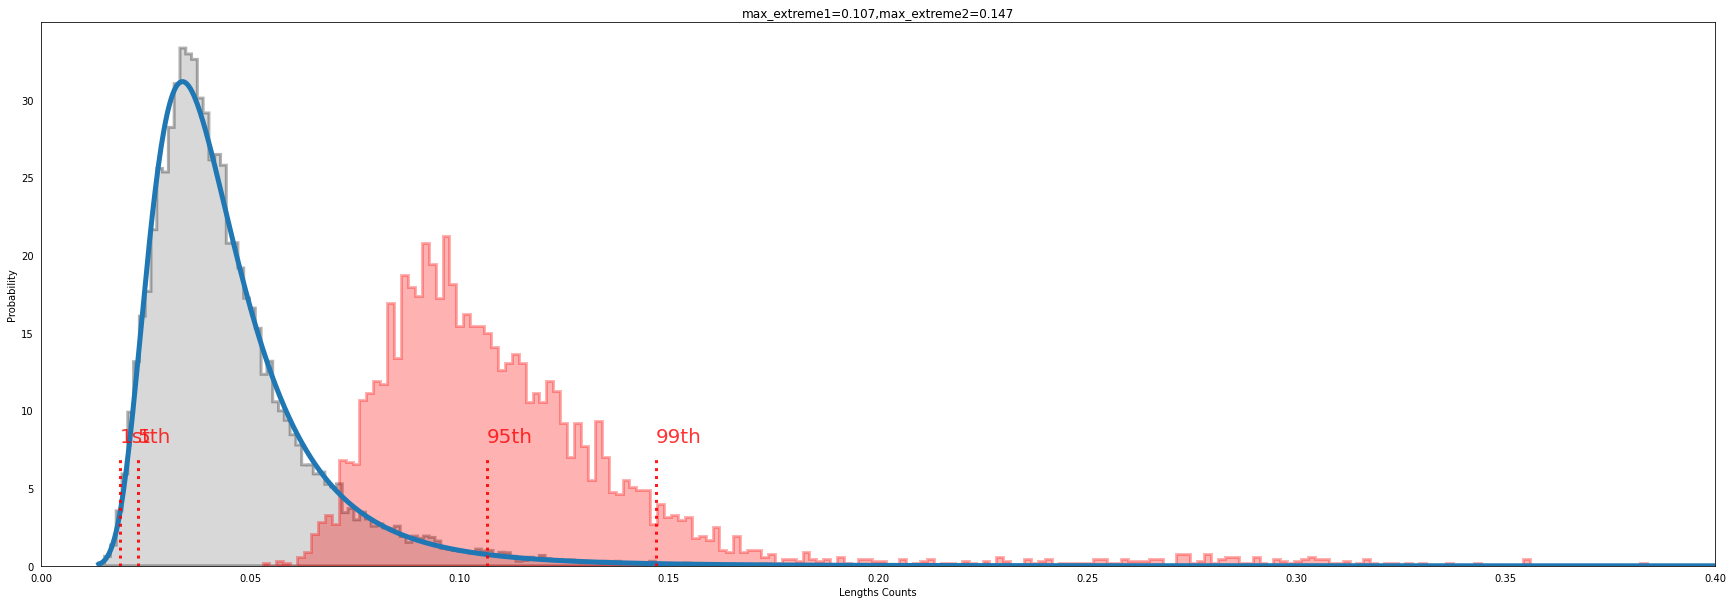

In [10]:
# Plot all training vs test histogram
# Change bin1 and bin2 as required
train=re_train_main
test=re_test_main
(c,log,scale,fig,ax)=Plot_Dist_Train_Extreme(train,test,bin1=500,bin2=200,interval1=0.95,interval2=0.99)

In [11]:
# Save distribution image
fig.savefig("../ExampleOutputs/gtu.hist.svg",dpi=300)

95% CI upper bound: 0.10659970165381911
99% CI upper bound: 0.14685000308245982
Median RE: 0.08736687153577805


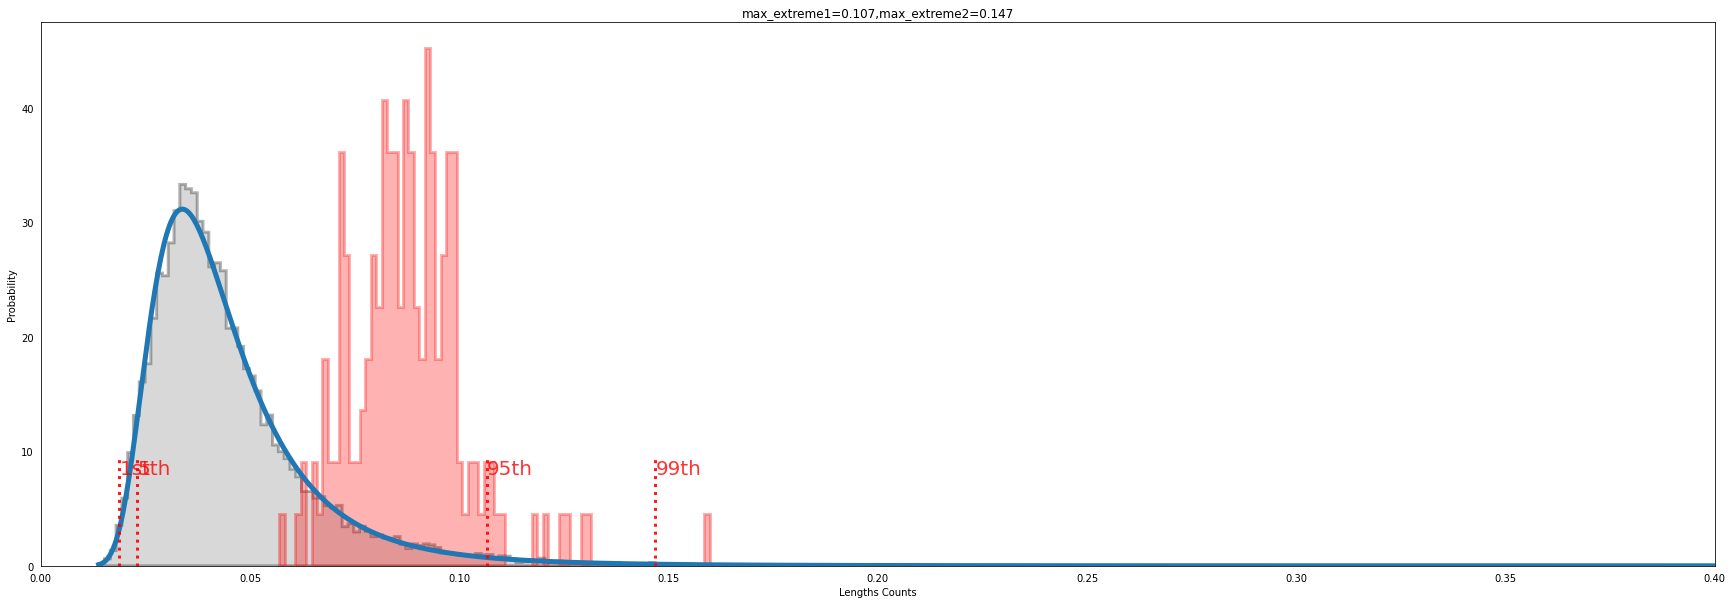

In [12]:
# Plot all training vs RE for selected families
# Change bin1 and bin2 as required
train=re_train_main
test=re_test_main.loc[re_test_main['Family']=='GT110-u']
(c,log,scale,fig,ax)=Plot_Dist_Train_Extreme(train,test,bin1=500,bin2=80,interval1=0.95,interval2=0.99)

In [13]:
# Save image with appropriate name
fig.savefig("../ExampleOutputs/GT110.hist.svg",dpi=300)

In [14]:
re_train_main

,Family,Err
0,GT51-lyso,0.026972
1,GT51-lyso,0.024585
2,GT51-lyso,0.072289
3,GT51-lyso,0.021156
4,GT51-lyso,0.024445
...,...,...
24887,GT66-C,0.036941
24888,GT22-C,0.034056
24889,GT22-C,0.041673
24890,GT66-C,0.060316


#### Boxplot

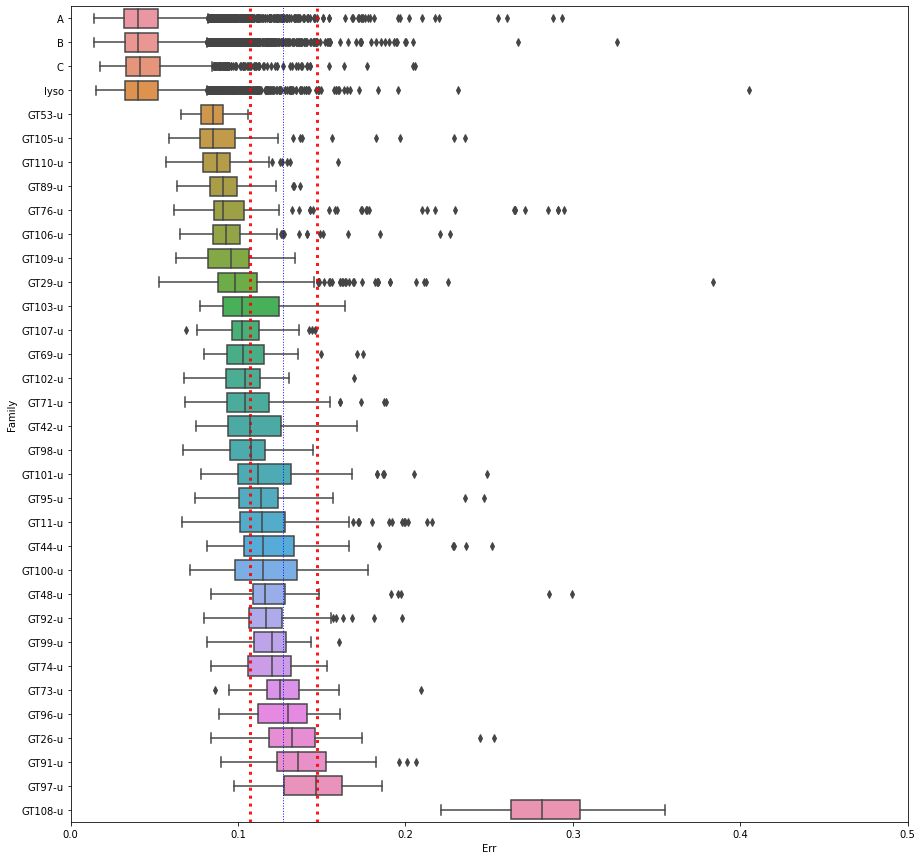

In [15]:
## Generate a boxplot with both training and testing data
g=gen_boxplot(re_train_main,re_test_main)

In [16]:
# Save boxplot to image file
g.figure.savefig("../ExampleOutputs/all_gtu.boxplot.svg",dpi=300)

## RE calculation and analysis against 9 cluster autoencoders

In [ ]:
# Calculate RE against cluster autoencoders
# This step can take long; 
# To avoid, load already provided dataset by uncommenting last line of this block 
# and comment the lines below
re_test=dict()
for i in grp:
    re_test[i] = reconstruction_error_calculation(model[i], df_test, le_fam, le_fold, cuda_gpu, criterion, vocab)

# re_test=dict()
# for i in grp:
#     unknown="../Datasets/gtu/gtu.RE_"+i+".csv"
#     re_test[i]=pd.read_csv(unknown)

/home/zzl/anaconda3/envs/GT_test/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
# Save RE for every cluster into separate files
for i in grp:
    outfile="../ExampleOutputs/gtu.RE_"+i+".csv"
    re_test[i].to_csv(outfile,index=False)

### RE analysis for cluster autoencoders

#### Plotting distributions

In [ ]:
# Plot all clusters
for i in grp:
    plt.figure(figsize=(30,10))
    plt.hist(np.asarray(re_train[i]["Err"], dtype=float),bins=100,alpha=0.7, density=True)
    plt.hist(np.asarray(re_ooc[i]["Err"]), alpha=0.35, bins=200, density=True)
    plt.hist(np.asarray(re_oof[i]["Err"]), alpha=0.35, bins=1000, density=True)
    plt.xlim(0,2)
    plt.title(i)
    plt.close
    figname="../ExampleOutputs/autoencoder_sub_dist"+i+".svg"
    plt.savefig(figname,dpi=300)

#### Generate SC, OOC and OOF values

In [ ]:
# Calculate mean or median values for each RE distribution
re_values=dict()
re_values['SC']=dict()
re_values['OOC']=dict()
re_values['OOF']=dict()
for i in grp:
    re_values['SC'][i]=re_train[i].median().values[0]
    re_values['OOC'][i]=re_ooc[i].mean().values[0]
    re_values['OOF'][i]=re_oof[i].mean().values[0]

re_values

#### Calculate Fold Assignment Score (FAS)

In [ ]:
testHere=re_test
col='Family'
allgtu=list()
allgtu.append(testHere[i].groupby(col).mean().reset_index()[col].tolist())
grpname=['Fam']
for i in grp:
    grpname.append(i)
    allgtu.append(testHere[i].groupby(col).mean()['Err'].tolist())
gtu_resub=pd.DataFrame(np.asarray(allgtu).T, columns=grpname)
gtu_resub

In [ ]:
subscore1=gtu_resub.apply(calcSubScore,args=(re_values,), axis=1)
subscore1.columns=grp
subscore1.insert(loc=0, column='Fam', value=gtu_resub['Fam'])
subscore1=subscore1.set_index('Fam')
subscore1.style.highlight_max(color = 'lightgreen', axis = 1)

#### Plot distribution of specific GT-u families vs GT clusters

In [ ]:
# Plot distribution of training vs test
scname='gtc0'
famname='GT89-u'
trainSC=re_train[scname]
# For plotting specific family within test results
test_here=re_test[scname]
testSC=test_here[test_here['Family'].str.contains(famname)]

(fig,ax)=Plot_Dist_SubClust_Extreme(trainSC,testSC,400,100)
ax.set_ylim(0,30)
ax.set_xlim(0,1.5)

In [ ]:
# Save distribution as image
ax.figure.savefig("../ExampleOutputs/gtc0_gt89.svg",dpi=300)